In this note we will take a look at the data provided for the Stochastic Modelling project. 

Following the information provided in the project documentation, we take today to be 1-Dec-2020. Let us load the option data and look at the data structure.

# Part2:
> 1. Collecting data from SPX_options.csv and SPY_options.csv
> 2. Calculate for average of the bid and offer(mid-price)
> 3. Discount factor:zero_rates_20201201.csv provided
> 4. Adjusting the Displaced-Diffusion(volatility $\alpha$ and shift factor $\beta$) and SABR model(Initial volatility: $\alpha$, correlation:$\rho$, volatility:v)
> 5. Goal: find the optimal parameter
> 6. Model parameter from the adjusting model: use the adjusted result to calculate the implied volatility, and plot the 'smile curve' and Implied market volatility.

### step1.

In [60]:
import datetime as dt
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.optimize import minimize

from pprint import pprint


spx_df = pd.read_csv('SPX_options.csv')
spx_df.tail()

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style
2067,20201201,20210219,P,5000000,1333.1,1350.5,E
2068,20201201,20210219,P,5100000,1431.8,1454.7,E
2069,20201201,20210219,P,5200000,1531.7,1554.6,E
2070,20201201,20210219,P,5300000,1631.5,1654.4,E
2071,20201201,20210219,P,5400000,1731.4,1752.3,E


- 'date' is the current date as mentioned above
- 'exdate' is the expiry date of the option
- 'cp_flag' will be 'C' for call options and 'P' for put options
- 'strike_price' is the strike price multiplied by 1000 (*why do this?*)
- 'exercise_style' is 'E' for European, and 'A' for American

### step2.

For each strike, the mid price is calculated as

\begin{equation*}
\begin{split}
\mbox{Mid Price} = \frac{\mbox{Best Bid} + \mbox{Best Ask}}{2}
\end{split}
\end{equation*}



In [61]:
spx_df['exdate'].unique()# 到期日提取

array([20201218, 20210115, 20210219], dtype=int64)

In [27]:
# spx_df['cp_flag'].value_counts()
# spx_df['cp_flag']

In [62]:
# 计算每个期权的中间价
spx_df['mid_price'] = (spx_df['best_bid'] + spx_df['best_offer']) / 2
mid_prices = spx_df['mid_price'].values  # 提取为 numpy 数组
print(mid_prices)  # 确认 mid_prices 是一个数组

[3559.05 3459.05 3359.15 ... 1543.15 1642.95 1741.85]


We can calculate the time-to-maturity $T$ in Python as follows:

In [63]:
dt.date(2020, 12, 1)

datetime.date(2020, 12, 1)

In [64]:
today = dt.date(2020, 12, 1)# 提取到期时间（年化）
# expiries = [pd.Timestamp(str(x)).date() for x in spx_df['exdate'].unique()]
expiries = [pd.Timestamp(str(x)).date() for x in spx_df['exdate']]

T = [(exdate-today).days/365.0 for exdate in expiries]
T_days = [(exdate-today).days for exdate in expiries]

# pprint(dict(zip(expiries, T)))
# print(T)

In [18]:
# expiries


The file "zero_rates_20201201.csv" contains information about the "zero rates" to be used for discounting.


In [65]:
strike_prices = spx_df['strike_price']# 行权价
strike_prices

0        100000
1        200000
2        300000
3        400000
4        500000
         ...   
2067    5000000
2068    5100000
2069    5200000
2070    5300000
2071    5400000
Name: strike_price, Length: 2072, dtype: int64

In [66]:
rates_df = pd.read_csv('zero_rates_20201201.csv')
rates_df.head()

,date,days,rate
0,20201201,7,0.102280
1,20201201,13,0.114128
2,20201201,49,0.216480
3,20201201,77,0.220707
4,20201201,104,0.219996


In [33]:
rates_df

,date,days,rate
0,20201201,7,0.102280
1,20201201,13,0.114128
2,20201201,49,0.216480
3,20201201,77,0.220707
4,20201201,104,0.219996
5,20201201,139,0.218208
6,20201201,167,0.216468
7,20201201,195,0.215228
8,20201201,286,0.212862
9,20201201,377,0.214085


### step3.

Note that the interest rates provided in the 'rate' column are in % unit. So for instance, to discount a cashflow paid 49 days from today, the discount factor is

\begin{equation*}
\begin{split}
D(0,T) = e^{-0.00216480 \times \frac{49}{365}}
\end{split}
\end{equation*}


If the payment date is not provided in the dataframe, you can perform linear interpolation for the corresponding zero rate.

In [67]:
from scipy.interpolate import interp1d

days_to_expiry1 = (expiries[1] - today).days# 获取到期时间对应的天数
print(days_to_expiry1)

17


In [68]:
zero_rate_curve = interp1d(rates_df['days'], rates_df['rate'])# 构造插值函数
rate1 = zero_rate_curve(days_to_expiry1)# 到期时间的贴现率
print(rate1)

0.12550044444444444


In [69]:
# calculate the Discount factor for multi-exp time
days_to_expiries = [(ex - today).days for ex in expiries]
rates = zero_rate_curve(days_to_expiries) / 100  # 插值得到对应的零息利率
discount_factors = np.exp(-rates * np.array(days_to_expiries) / 365)  # calculate Discount factor

In [70]:
rates

array([0.001255  , 0.001255  , 0.001255  , ..., 0.00220628, 0.00220628,
       0.00220628])

### step4.Displaced-Diffusion model(Calibrated parameter: $\sigma, \beta$)

In [71]:
# Black-Scholes pricing function
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [30]:
# S = 100.0
# r = 0.05
# T = 2.0
# K = S * np.exp(r*T)
# sigma = 0.4

In [31]:
# print('Call price: %.4f' % BlackScholesCall(S, K, r, sigma, T))

Call price: 22.2703


##### Modified based on Black-Scholes pricing function:
> 1.Added parameter Beta\
> 2.adjust the formula mode of the d1 and d2 based on the shifted of the S\
> 3.The portion of the return option price has not changed

In [72]:
def displaced_diffusion_price(S, K, T, r, sigma, beta, option_type='call'):
    # 计算位移后的标的资产价格
    S_shifted = beta * S + (1 - beta) * K# S is replaced by the underlying price after the shift
    d1 = (np.log(S_shifted / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # 计算期权价格
    if option_type == 'call':
        return S_shifted * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S_shifted * norm.cdf(-d1)


#### Minimize the error between the market price and the model price：
> 1. Using the displaced_diffusion_price function to calculate the model price
> 2. Comparing the model and the market price and returning the sum of squares of error(误差平方和)

In [73]:
def calibration_objective(params, market_prices, S, K, T, r, option_type):
    sigma, beta = params  # 参数列表
    # print(S, K, T, r, option_type)
    # model_prices = [
    #     displaced_diffusion_price(S, k, t, r, sigma, beta, option_type) for k, t in zip(K, T)
    # ]
    # model_prices = displaced_diffusion_price(S, K, T, r, sigma, beta, option_type)
    # print(option_type)

    model_prices = [
        displaced_diffusion_price(S, k, t, r_, sigma, beta, opt) 
        for k, t, r_, opt in zip(K, T, r, option_type)]
    
    # print(np.array(model_prices).shape, np.array(market_prices).shape)
    # 误差平方和
    err = np.mean((np.array(model_prices) - np.array(market_prices))**2)
    print(err)
    return err

### step5. find the optimal parametre

In [74]:
len(strike_prices)

2072

In [41]:
len(expiries)

2072

In [42]:
# model_prices = displaced_diffusion_price(3662.45, strike_prices, T, rates, 0.2, 0.5, 'call')
# print(model_prices)

In [50]:
# initial_guess = [0.2, 0.5]
# 
# # 市场数据
# S = 3662.45  # 当前标的资产价格（示例）
# K = strike_prices  # 行权价列表
# T = T  # 到期时间列表（年化）
# r = rates  # 零息利率
# market_prices = mid_prices  # 市场中间价
# option_type = [cp_flag for cp_flag in spx_df['cp_flag']]
# print(option_type)

# model_prices = displaced_diffusion_price(S, K, T, r, 0.2, 0.5, 'call')
# print(K[:5], rates[:5], T[:5])

['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',

In [76]:
initial_guess = [0.2, 0.5]

# 市场数据
S = 3662.45  # 当前标的资产价格（示例）
K = strike_prices / 1000  # 行权价列表
T = T  # 到期时间列表（年化）
r = rates  # 零息利率
market_prices = mid_prices  # 市场中间价
option_type = ['call' if cp_flag == 'C' else 'put' 
               for cp_flag in spx_df['cp_flag']]

# model_prices = displaced_diffusion_price(S, K, T, r, 0.2, 0.5, 'call')


# 校准
result = minimize(calibration_objective, initial_guess, args=(market_prices, S, K, T, r, option_type), bounds=[(0.0, 1.0), (0.0, 1.0)])
optimal_sigma, optimal_beta = result.x

print("Optimal sigma:", optimal_sigma)
print("Optimal beta:", optimal_beta)

145046.83436937912
145046.8341449376
145046.82859322036
68129.44351174716
68129.44157254396
68129.44313657358
6395.936274687862
6395.93660012248
6395.935463307509
392.5783074100096
392.5784014708689
392.57828461023524
116.91289076946207
116.91292465440347
116.91287673649487
69.63054350690709
69.63054842124421
69.63054399362268
68.52692033181071
68.52692072459095
68.52692039466423
68.51970031754948
68.51970032321184
68.5197003169911
68.51969880774247
68.51969880774917
68.51969880780656
68.5196988077599
68.51969880776
68.51969880775648
68.5196988077428
68.51969880774807
68.51969880779423
68.51969880774269
68.51969880774911
68.51969880780369
68.51969880774264
68.51969880774914
68.51969880780581
68.5196988077424
68.5196988077491
68.51969880780598
68.51969880774293
68.51969880774953
68.51969880780632
68.51969880774243
68.51969880774908
68.51969880780679
68.5196988077424
68.5196988077491
68.51969880780598
Optimal sigma: 0.19523378805932282
Optimal beta: 0.9992313894173689


In [24]:
# len(spx_df['cp_flag'])

2072

### step6. Verification and plotting

In [82]:
# 使用最优参数计算模型价格
# model_prices = [
#     displaced_diffusion_price(S, k, t, r, optimal_sigma, optimal_beta, 'call') for k, t in zip(K, T)
# ]
# model_prices = displaced_diffusion_price(S, K, T, r, optimal_sigma, optimal_beta, 'call') 
model_prices = [
        displaced_diffusion_price(S, k, t, r_, optimal_sigma, optimal_beta, opt) 
        for k, t, r_, opt in zip(K, T, r, option_type)]

# 比较模型价格和市场价格
print("Market Prices:", market_prices[-5:])
print("Model Prices:", model_prices[-5:])

Market Prices: [1341.8  1443.25 1543.15 1642.95 1741.85]
Model Prices: [1334.1388729153932, 1433.9940617711495, 1533.8603431064903, 1633.7315367034962, 1733.6048449855266]


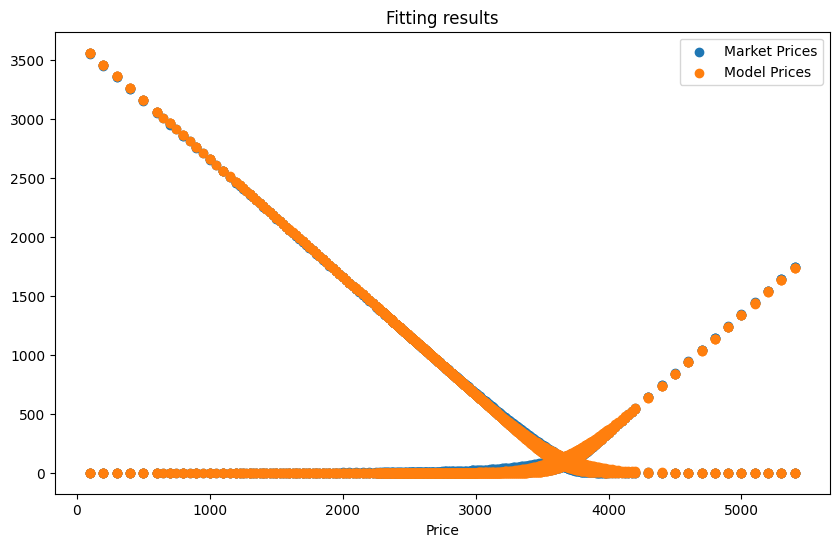

In [125]:
import matplotlib.pyplot as plt
# 绘制
plt.figure(figsize=(10, 6))

plt.scatter(K, market_prices, label='Market Prices', )
plt.scatter(K, model_prices, label='Model Prices')
plt.xlabel('Price')
# plt.ylabel('Implied Volatility')
plt.legend()
plt.title('Fitting results')
plt.show()

In [126]:
import math
def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)


def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def impliedVolatility(S, K, r, price, T, payoff='call'):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol



# 隐含波动率计算（使用之前的函数）
implied_vols = [
    impliedVolatility(S, k, r_, price, t, opt) for k, price, t, r_, opt in zip(K, market_prices, T, r, option_type)
]
implied_vols = np.array(implied_vols)

valid_implied_vols = np.logical_not(np.isnan(implied_vols))

model_vols = [
    impliedVolatility(S, k, r_, price, t, opt) for k, price, t, r_, opt in zip(K, model_prices, T, r, option_type)
]

model_vols = np.array(model_vols)
valid_model_vols = np.logical_not(np.isnan(model_vols))




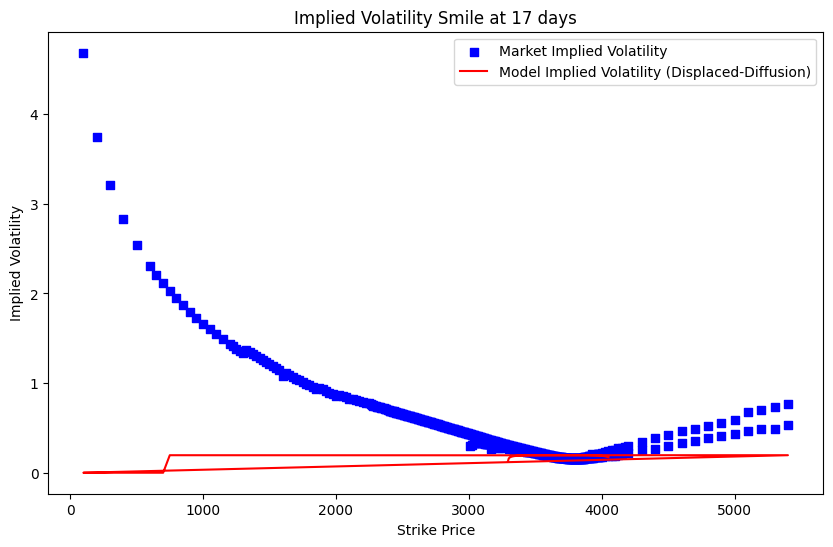

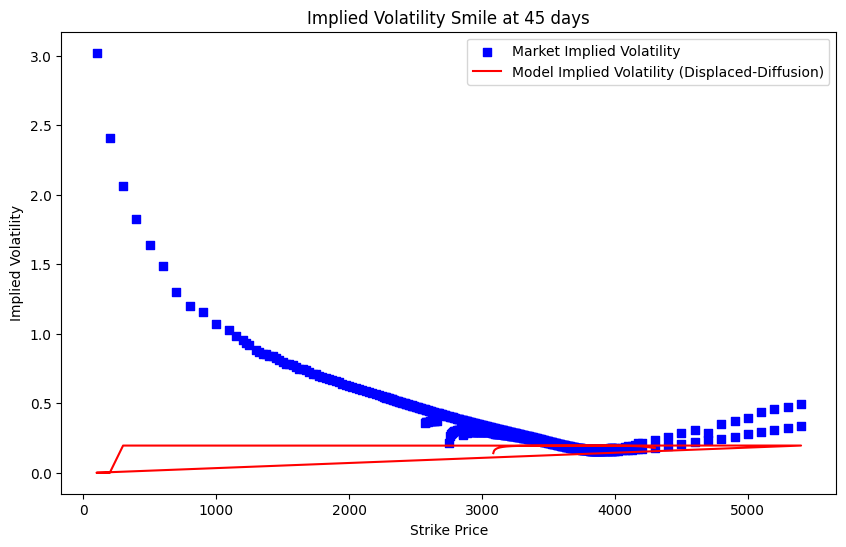

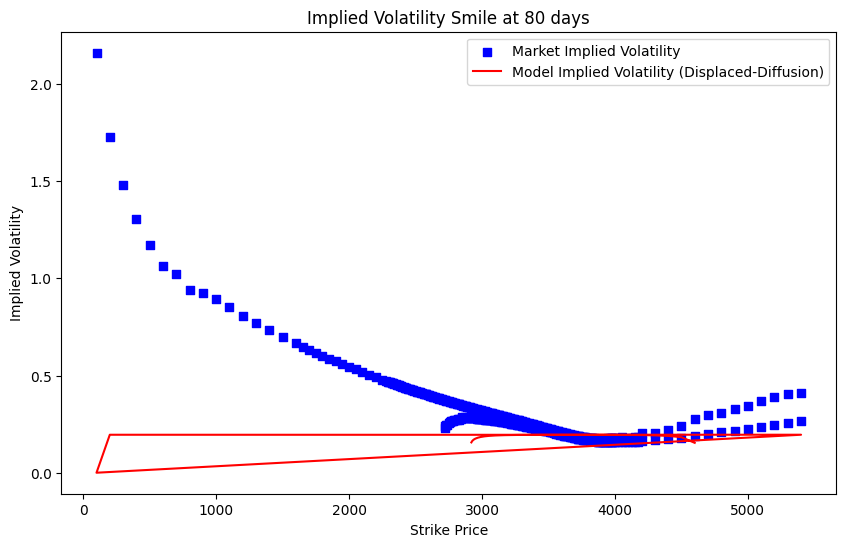

In [135]:
T_days = np.array(T_days)
unique_days = np.unique(T_days)

for unique_day in unique_days:
    
    K_ = K[T_days == unique_day]
    implied_vols_ = implied_vols[T_days == unique_day]
    valid_implied_vols_ = valid_implied_vols[T_days == unique_day]
    model_vols_ = model_vols[T_days == unique_day]
    valid_model_vols_ = valid_model_vols[T_days == unique_day]
    
    plt.figure(figsize=(10, 6))   
    plt.scatter(K_[valid_implied_vols_], implied_vols_[valid_implied_vols_], 
                marker='s', color = "blue",
                label='Market Implied Volatility') 
    
    plt.plot(K_[valid_model_vols_], model_vols_[valid_model_vols_], 
             linestyle='-', color = "red",
             label='Model Implied Volatility (Displaced-Diffusion)') 
    

    # plt.close()
    # 绘制
    # plt.figure(figsize=(10, 6))
    # plt.scatter(K_[valid_implied_vols_], implied_vols_[valid_implied_vols_], label='Market Implied Volatility', marker='o')
    # plt.scatter(K_[valid_model_vols_], model_vols_[valid_model_vols_], label='Model Implied Volatility (Displaced-Diffusion)', linestyle='--')
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.legend()
    plt.title(f'Implied Volatility Smile at {unique_day} days')
    plt.show()

In [122]:
implied_vols[-100:]

(2072,)

In [110]:
model_vols[-100:]

array([0.19532572, 0.19532439, 0.19532299, 0.19532154, 0.19532079,
       0.19532003, 0.19531845, 0.19531679, 0.19531507, 0.19531327,
       0.19531235, 0.1953114 , 0.19530944, 0.19530739, 0.19530526,
       0.19530303, 0.19530188, 0.1953007 , 0.19529827, 0.19529573,
       0.19529307, 0.1952903 , 0.19528887, 0.1952874 , 0.19528437,
       0.19528121, 0.1952779 , 0.19527444, 0.19527265, 0.19527082,
       0.19526703, 0.19526307, 0.19525892, 0.19525459, 0.19525234,
       0.19525005, 0.19524529, 0.19524032, 0.1952351 , 0.19522964,
       0.19522681, 0.19522392, 0.19521792, 0.19521163, 0.19520504,
       0.19519813, 0.19519454, 0.19519087, 0.19518326, 0.19517527,
       0.19516689, 0.19515809, 0.19515352, 0.19514884, 0.19513912,
       0.19512892, 0.19511819, 0.19510691, 0.19510105, 0.19509504,
       0.19508256, 0.19506943, 0.19505561, 0.19504106, 0.1950335 ,
       0.19502574, 0.19500959, 0.19499258, 0.19497466, 0.19495576,
       0.19494592, 0.19493582, 0.19491479, 0.1948926 , 0.19486